In [18]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [44]:
df = pd.read_excel("https://sportsbookreviewsonline.com/scoresoddsarchives/nba/nba%20odds%202018-19.xlsx")


In [20]:
df.Open = np.where(df.Open.str.lower() == 'pk',0,df.Open.values)
df.Close = np.where(df.Close.str.lower() == 'pk',0,df.Close.values)
df['2H'] = np.where(df['2H'].str.lower() == 'pk',0,df['2H'].values)

In [21]:
dateDict = {}
dataDict = {}
gameCounter = {} # counters by date

teamrecords = {
    'Atlanta': {
        'wins' : 0,
        'losses' : 0
    },
    'Boston': {
        'wins' : 0,
        'losses' : 0
    },
    'Brooklyn': {
        'wins' : 0,
        'losses' : 0
    },
    'Charlotte': {
        'wins' : 0,
        'losses' : 0
    },
    'Chicago': {
        'wins' : 0,
        'losses' : 0
    },
    'Cleveland': {
        'wins' : 0,
        'losses' : 0
    },
    'Dallas': {
        'wins' : 0,
        'losses' : 0
    },
    'Denver': {
        'wins' : 0,
        'losses' : 0
    },
    'Detroit': {
        'wins' : 0,
        'losses' : 0
    },
    'GoldenState': {
        'wins' : 0,
        'losses' : 0
    },
    'Houston': {
        'wins' : 0,
        'losses' : 0
    },
    'Indiana': {
        'wins' : 0,
        'losses' : 0
    },
    'LAClippers': {
        'wins' : 0,
        'losses' : 0
    },
    'LALakers': {
        'wins' : 0,
        'losses' : 0
    },
    'Memphis': {
        'wins' : 0,
        'losses' : 0
    },
    'Miami': {
        'wins' : 0,
        'losses' : 0
    },
    'Milwaukee': {
        'wins' : 0,
        'losses' : 0
    },
    'Minnesota': {
        'wins' : 0,
        'losses' : 0
    },
    'NewOrleans': {
        'wins' : 0,
        'losses' : 0
    },
    'NewYork': {
        'wins' : 0,
        'losses' : 0
    },
    'OklahomaCity': {
        'wins' : 0,
        'losses' : 0
    },
    'Orlando': {
        'wins' : 0,
        'losses' : 0
    },
    'Philadelphia': {
        'wins' : 0,
        'losses' : 0
    },
    'Phoenix': {
        'wins' : 0,
        'losses' : 0
    },
    'Portland': {
        'wins' : 0,
        'losses' : 0
    },
    'Sacramento': {
        'wins' : 0,
        'losses' : 0
    },
    'SanAntonio': {
        'wins' : 0,
        'losses' : 0
    },
    'Toronto': {
        'wins' : 0,
        'losses' : 0
    },
    'Utah': {
        'wins' : 0,
        'losses' : 0
    },
    'Washington': {
        'wins' : 0,
        'losses' : 0
    }
    
}



In [22]:
i = 0

def ml_to_pct(ml):
    
    if (ml > 0):
        pct = 100/(100 + ml)
    if (ml < 0):
        pct = ml/(ml - 100)
    return pct


seasonString = '201819'
gameID = ''
for ix, row in df.iterrows():
    if i%2:
        # odd row
        if (row['Date'] != gameDict['Date']):
            print ('Error: data does not match template', row)
        gameDict = dataDict.get(gameID,{}) #ask dad, is this necessary?
        gameDict['Home'] = row['Team']
        gameDict['H1'] = row['1st']
        gameDict['H2'] = row['2nd']
        gameDict['H3'] = row['3rd']
        gameDict['H4'] = row['4th']
        gameDict['HF'] = row['Final']
        opening = float(row['Open'])
        if (opening > 100):
            gameDict['OpenOU'] = opening
        elif (opening < 100):
            gameDict['OpenSpread'] = opening
            
        closing = float(row['Close'] )         
        if (closing > 100):
            gameDict['CloseOU'] = closing
        elif (closing < 100):
            gameDict['CloseSpread'] = closing
    
        gameDict['HomeML'] = row['ML']
        secondHalf = float(row['2H'])
        if secondHalf > 50:
            gameDict['2HOU'] = row['2H']
        elif secondHalf < 50:
            gameDict['2HSpread'] = row['2H']
    
        if int(gameDict['HomeML']) < int(gameDict['AwayML']): #populates favorite and underdog based on ml
            gameDict['Favorite'] = gameDict['Home']
            gameDict['Underdog'] = gameDict['Away']
        else:
            gameDict['Favorite'] = gameDict['Away']
            gameDict['Underdog'] = gameDict['Home']
        
        total = int(gameDict['HF']) + int(gameDict['AF'])
        
        if (total < float(gameDict['CloseOU'])): #Did the game end up over or under?
            gameDict['OUResult'] = 'Under'
        elif (total > float(gameDict['CloseOU'])):
            gameDict['OUResult'] = 'Over'
        elif (total == float(gameDict['CloseOU'])):
            gameDict['OUResult'] = 'Push'
        gameDict['Winner'] = gameDict['HF']>gameDict['AF'] and gameDict['Home'] or gameDict['Away'] #Who won?
        if gameDict['Favorite'] == gameDict['Winner']: #Upset Check
            gameDict['Upset?'] = 'No'
        else:
            gameDict['Upset?'] = 'Yes'
            
        favScore = (gameDict['Favorite'] == gameDict['Home']) and gameDict['HF'] or gameDict['AF']
        dogScore = (gameDict['Favorite'] == gameDict['Home']) and gameDict['AF'] or gameDict['HF']
        margin = favScore - dogScore #Margin of victory - should be negative if upset
        gameDict['Margin'] = margin
        line = gameDict['CloseSpread']
        
        if (margin > line): #Did the favorite cover the spread?
            gameDict['Cover?'] = 'Yes'
        elif (margin < line):
            gameDict['Cover?'] = 'No'
        elif (margin == line):
            gameDict['Cover?'] = 'Push'
            
            
        gameDict['HomeMLPct'] = ml_to_pct(gameDict['HomeML'])
        gameDict['AwayMLPct'] = ml_to_pct(gameDict['AwayML'])
        gameDict['TotalMLPct'] = gameDict['HomeMLPct'] + gameDict['AwayMLPct']
        
        gameDict['HomeWins'] = teamrecords[gameDict['Home']]['wins']
        gameDict['HomeLosses'] = teamrecords[gameDict['Home']]['losses']
        if (gameDict['HomeWins']+gameDict['HomeLosses'] == 0): #handling divide by zero exception for Wpct of each team's first game
             gameDict['HomeWpct'] = round(0,3)
        else:
            gameDict['HomeWpct'] = round(gameDict['HomeWins']/(gameDict['HomeWins']+gameDict['HomeLosses']),3)
        
        gameDict['AwayWins'] = teamrecords[gameDict['Away']]['wins']
        gameDict['AwayLosses'] = teamrecords[gameDict['Away']]['losses']
        if (gameDict['AwayWins']+gameDict['AwayLosses'] == 0):
            gameDict['AwayWpct'] = round(0,3)
        else:
            gameDict['AwayWpct'] = round(gameDict['AwayWins']/(gameDict['AwayWins']+gameDict['AwayLosses']),3)
        
        #Updates each team's record at this point in time - result of game not included in the table since we only care about the information available before the game
        if gameDict['HF'] > gameDict['AF']:
            teamrecords[str(gameDict['Home'])]['wins'] += 1
            teamrecords[str(gameDict['Away'])]['losses'] += 1
        else:
            teamrecords[str(gameDict['Home'])]['losses'] += 1
            teamrecords[str(gameDict['Away'])]['wins'] += 1
        
        
    else:
        gameDict = {}
        theCount = gameCounter.get(row.Date,0)
        theCount += 1
        gameCounter[row.Date] = theCount
        gameID = seasonString + str(row.Date).zfill(4) + str(theCount).zfill(3)
        gameDict['gameID'] = gameID
        gameDict['Date'] = row['Date']
        gameDict['Away'] = row['Team']
        gameDict['A1'] = row['1st']
        gameDict['A2'] = row['2nd']
        gameDict['A3'] = row['3rd']
        gameDict['A4'] = row['4th']
        gameDict['AF'] = row['Final']
        opening = float(row['Open'])
        if (opening > 100):
            gameDict['OpenOU'] = opening
        elif (opening < 100):
            gameDict['OpenSpread'] = opening
            
        closing = float(row['Close'] )         
        if (closing > 100):
            gameDict['CloseOU'] = closing
        elif (closing < 100):
            gameDict['CloseSpread'] = closing
            
        gameDict['AwayML'] = row['ML']
        
        secondHalf = row['2H']
        if (str(secondHalf).lower() == 'pk'):
            gameDict['2HSpread'] = 100
        elif secondHalf > 50:
            gameDict['2HOU'] = row['2H']
        elif secondHalf < 50:
            gameDict['2HSpread'] = row['2H']
        else:
            print ('Error: data does not match template', secondHalf)
            break
        
        dataDict[gameID] = gameDict
    i += 1
    

        




In [23]:
myOrder = ['gameID', 'Date','Home','Away','HomeWpct','AwayWpct','Favorite','Underdog','Winner','Upset?','H1', 'H2', 'H3', 'H4', 'HF','A1', 'A2', 'A3', 'A4', 'AF','HomeML', 'AwayML', 'HomeMLPct', 'AwayMLPct', 'TotalMLPct','OpenOU', 'CloseOU','OUResult', 'OpenSpread', 'CloseSpread','Margin', 'Cover?', '2HOU', '2HSpread', ]

In [24]:
newData = []
for key in dataDict.keys():
    gDict = dataDict[key]
    newDict = {}
    for gk in myOrder:
        newDict[gk]= gDict[gk]
    newData.append(newDict)
    
dfNew = pd.DataFrame(newData)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
dfNew
    

,gameID,Date,Home,Away,HomeWpct,AwayWpct,Favorite,Underdog,Winner,Upset?,H1,H2,H3,H4,HF,A1,A2,A3,A4,AF,HomeML,AwayML,HomeMLPct,AwayMLPct,TotalMLPct,OpenOU,CloseOU,OUResult,OpenSpread,CloseSpread,Margin,Cover?,2HOU,2HSpread
0,2018191016001,1016,Boston,Philadelphia,0.000,0.000,Boston,Philadelphia,Boston,No,21,26,30,28,105,21,21,24,21,87,-200,170,0.666667,0.370370,1.037037,208.5,211.5,Under,5.0000,4.5,18,Yes,106.0,1.0
1,2018191016002,1016,GoldenState,OklahomaCity,0.000,0.000,GoldenState,OklahomaCity,GoldenState,No,31,26,26,25,108,23,24,32,21,100,-1100,711,0.916667,0.123305,1.039971,223.5,220.5,Under,11.5000,12.0,8,No,108.5,4.5
2,2018191017001,1017,Indiana,Memphis,0.000,0.000,Indiana,Memphis,Indiana,No,27,29,20,35,111,16,23,19,25,83,-325,263,0.764706,0.275482,1.040188,209.0,204.5,Under,7.0000,7.5,28,Yes,99.0,1.0
3,2018191017002,1017,Charlotte,Milwaukee,0.000,0.000,Milwaukee,Charlotte,Milwaukee,No,23,31,29,29,112,36,31,26,20,113,144,-165,0.409836,0.622642,1.032478,217.0,222.0,Over,1.5000,3.0,1,No,114.0,2.5
4,2018191017003,1017,Orlando,Miami,0.000,0.000,Miami,Orlando,Orlando,Yes,25,29,25,25,104,31,20,27,23,101,115,-135,0.465116,0.574468,1.039584,210.5,208.0,Under,2.0000,2.5,-3,No,103.0,3.0
5,2018191017004,1017,Detroit,Brooklyn,0.000,0.000,Detroit,Brooklyn,Detroit,No,24,27,32,20,103,29,22,25,24,100,-255,211,0.718310,0.321543,1.039853,212.0,213.0,Under,4.5000,6.0,3,No,110.5,4.0
6,2018191017005,1017,NewYork,Atlanta,0.000,0.000,NewYork,Atlanta,NewYork,No,23,49,34,20,126,24,25,35,23,107,-170,148,0.629630,0.403226,1.032855,213.5,216.5,Over,3.5000,4.0,19,Yes,106.0,4.0
7,2018191017006,1017,Toronto,Cleveland,0.000,0.000,Toronto,Cleveland,Toronto,No,28,32,30,26,116,25,22,28,29,104,-1300,797,0.928571,0.111483,1.040054,214.0,215.5,Over,11.5000,12.5,12,No,106.5,3.0
8,2018191017007,1017,Houston,NewOrleans,0.000,0.000,Houston,NewOrleans,NewOrleans,Yes,29,25,30,28,112,35,36,30,30,131,-345,278,0.775281,0.264550,1.039831,229.5,233.0,Over,7.5000,8.0,-19,No,114.0,9.5
9,2018191017008,1017,SanAntonio,Minnesota,0.000,0.000,SanAntonio,Minnesota,SanAntonio,No,31,25,25,31,112,23,29,31,25,108,-145,125,0.591837,0.444444,1.036281,210.5,212.0,Over,1.0000,2.5,4,Yes,105.0,0.5


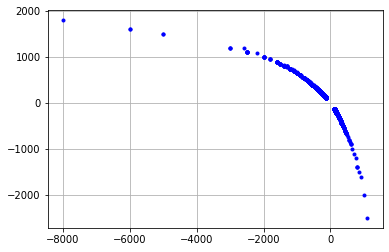

In [25]:
dfExp =  dfNew[( dfNew.HomeML > 0 ) | (dfNew.AwayML > 0 )]
plt.figure()
plt.plot(dfExp.HomeML, dfExp.AwayML,'b.')
plt.grid()
plt.show()

719.8652479266185 5.292500954315396
0.001233958490636222 6.388599049427259e-06
-0.15882823467519888 0.0017941091881615403
-18.894455202352518 0.5592973332652179


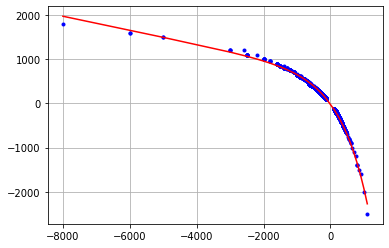

In [26]:
def fit_func(x, A, B, C, D):
    return -A*(np.exp(B*x)-1) + C*x + D
    
A0 = 1000
B0 = .005
C0 = -1
D0 = 0

par, cov = curve_fit(fit_func, dfExp.HomeML, dfExp.AwayML, p0=(A0,B0,C0,D0))

A, B, C, D = par
dA, dB, dC, dD = np.sqrt(np.diag(cov))

xfit = np.array(sorted(dfExp.HomeML.values))
yfit = fit_func(xfit, A, B, C, D)
plt.figure()
plt.plot(dfExp.HomeML, dfExp.AwayML,'b.')
plt.plot(xfit, yfit, 'r-')
plt.grid()

print(A,dA)
print(B,dB)
print(C,dC)
print(D,dD)

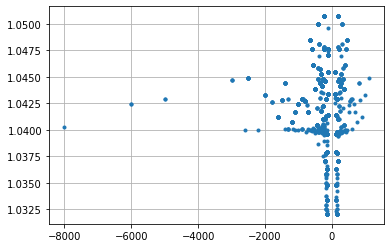

In [27]:
plt.figure()
plt.plot(dfNew.HomeML, dfNew.TotalMLPct, '.')
plt.grid()

In [28]:
homeFavs = dfNew[dfNew['Home'] == dfNew['Favorite']]
lowPct = homeFavs[homeFavs['TotalMLPct'] < 1.04]

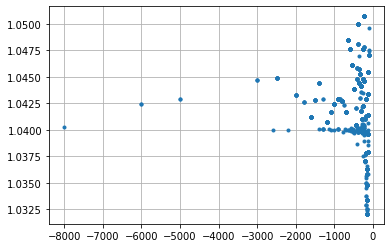

In [29]:
plt.figure()
plt.grid()
plt.plot(homeFavs.HomeML, homeFavs.TotalMLPct, '.')

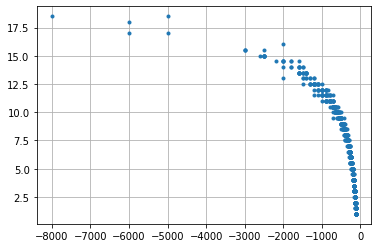

In [30]:
plt.figure()
plt.plot(homeFavs.HomeML, homeFavs.CloseSpread, '.')



plt.grid()

In [31]:
def fit_func(x, A, B, C, D):
    return np.log(-x/A + D)*B + C*x

39.979154845654286 1.0348096860051332
3.894772878955025 0.04317446614953104
0.00031783025492223584 3.5544119742555685e-05
-1.619485417684729 0.08058636900864252


<Figure size 432x288 with 0 Axes>

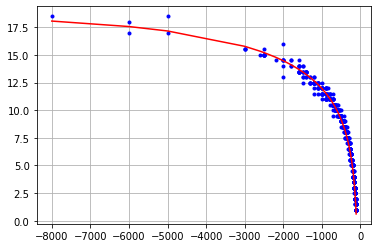

In [32]:

plt.figure()

A0=1000
B0=10
C0=0.0001
D0=1

par, cov = curve_fit(fit_func, homeFavs.HomeML, homeFavs.CloseSpread, p0=(A0,B0,C0,D0))

A, B, C, D = par
dA, dB, dC, dD = np.sqrt(np.diag(cov))

xfit = np.array(sorted(homeFavs.HomeML.values))
yfit = fit_func(xfit, A, B, C, D)

plt.figure()
plt.plot(homeFavs.HomeML, homeFavs.CloseSpread,'b.')
plt.plot(xfit, yfit, 'r-')
plt.grid()

print(A,dA)
print(B,dB)
print(C,dC)
print(D,dD)

In [43]:
dfNew[dfNew['CloseSpread'] > dfNew['OpenSpread']].gameID.count()
#dfNew[dfNew['CloseSpread'] < dfNew['OpenSpread']].count
#dfNew[dfNew['CloseSpread'] == dfNew['OpenSpread']].count

704